In [1]:
# imports
import sys
import time
from IPython.core.debugger import set_trace

import numpy as np
from numpy import linalg as LA
import math
import random

import matplotlib
#matplotlib.use('Agg')

import matplotlib.pyplot as plt

from itertools import count

import torch#
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import Intersection_finder_absoluteCoordinates_Module as I
import VertexObject as VO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [2]:
class DQN(nn.Module):
    """DQN class with h input nodes and output output nodes"""
    def __init__(self, h, outputs):
        super(DQN, self).__init__()
        self.fcn1 = nn.Linear(h,512)
        self.fcn2 = nn.Linear(512,512)
        self.fcn3 = nn.Linear(512,256)
        self.fcn4 = nn.Linear(256,128)
        self.fcn6 = nn.Linear(128,64)
        self.fcn5 = nn.Linear(64,outputs)

    def forward(self, x):
        x = F.relu(self.fcn1(x))
        x = F.relu(self.fcn2(x))
        x = F.relu(self.fcn3(x))
        x = F.relu(self.fcn4(x))
        x = F.relu(self.fcn6(x))
        x = self.fcn5(x)
        return x


def select_action_DQN(state):
    """Selects an action either based on policy or randomly"""
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    a = 0
    if sample > eps_threshold:
        with torch.no_grad():
            # return the index of the max in output tensor
            state = state.to(device)
            a = (policy_net(state.flatten()).argsort()).cpu().numpy()
            a = np.flip(a)
    else:
        # return random bool
        a = np.random.choice(n_actions, n_actions,replace=False)
    #print("Action selected:", a)
    return [int(i) for i in a]

def init_weights(m):
    """Inits weights of m by random for linear layers"""
    if type(m) == nn.Linear:
        torch.nn.init.zeros_(m.weight)
        m.bias.data.fill_(0.00)

# maybe change reward such that it can be calculated after the experience
# this way training can be made faster by keeping experiences
# num steps is a bad thing as it is not         
def optimise_model_memory(batch_size):
    """
    This function performs one training step on policy net.
    
    State action value Q(s,a) is compared to r + Q_t(s',a')
    and a step of the optimiser is taken.
    """
    x_batch, y_batch = [], []
    action_batch = []
    batch_size = min(len(memory), batch_size)
    minibatch = random.sample(memory, batch_size)
    for state, action, reward, next_state, done in minibatch:
        x_batch.append(state.flatten())
        state = state.to(device)
        next_state = next_state.to(device)
        y_target = reward if done else reward + gamma * float((target_net(next_state.flatten()).max()).to('cpu'))
        action_batch.append(int(action))
        y_batch.append(y_target)
        #.type(torch.FloatTensor)
    with torch.no_grad():
        x_batch = torch.cat(x_batch).reshape((batch_size, n_inputs)).to(device)
        y_batch = torch.tensor(y_batch).type(torch.FloatTensor).squeeze().to(device)
        action_batch = torch.tensor(action_batch).reshape((batch_size,1)).to(device)
    optimizer.zero_grad()
    out = policy_net(x_batch).reshape((batch_size, n_actions))
    out = out.gather(1, action_batch).squeeze()
    loss = F.smooth_l1_loss(out, y_batch)
    #loss = F.mse_loss(out, y_batch)
    loss.backward()
    # clip error values to values between -1 and 1
    #for param in policy_net.parameters():
     #   param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [3]:
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# set up training as testing data

# load data in torch format
X_data = np.load('PFC_data_pocas_wrtJ_sign_cut.npy')
y_data = np.load('SV_true_pocas_wrtJ_sign_cut.npy')
print("Data loaded")
np.load = np_load_old


Data loaded


PFCatts = 'pt', 'eta', 'phi', 'charge', 'dxy', 'dz', 'pv_x', 'pv_y', 'pv_z',

            0     1     2        3          4    5    6         7       8 
            
           'theta', 'chi2', 'normalizedChi2','ndof', 'nPixelHits', 'deltaEta',
           
              9        10            11         12       13            14
              
           'deltaPhi', 'jetPtFrac', 
           
                15            16 
                
           'ptError', 'etaError', 'phiError',  'dxyError', 'dzError'
           
               17          18            19         20         21


In [4]:
num_pfc_cut = 8 # maxp
# do not use the most complicated parameters
X_data = X_data[:,:num_pfc_cut,:17] # do not include error for track params
print(f"Number of jets: {X_data.shape}")

# assign training and testing data
# randomize data
#idx = np.random.choice(X_data.shape[0], X_data.shape[0],replace=False)
#print(idx)
#X_data = X_data[idx]
#y_data = y_data[idx]

print(f"Number of jets: {X_data.shape}")
# split data to training, testing, validation data
X_train = X_data[:25000]
y_train = y_data[:25000]

X_test = X_data[25000:]
y_test = y_data[25000:]
if len(X_test) == 0:
    print("To much training data")

'''
X_val = X_data[32000:]
y_val = y_data[32000:]
if len(X_val) == 0:
    print("To much testing data")
'''

Number of jets: (42390, 8, 17)
Number of jets: (42390, 8, 17)


'\nX_val = X_data[32000:]\ny_val = y_data[32000:]\nif len(X_val) == 0:\n    print("To much testing data")\n'

Class definitions

In [5]:
#print(X_train.shape)
Env_test = VO.TrackEnvironment(X_train[0])
n_actions = 1 + 2 * Env_test.state.shape[2]
print(f"# actions: {n_actions}")

n_inputs = Env_test.state.shape[2] * Env_test.state.shape[3]
print(f"# inputs: {n_inputs}")


#for i in range(X_train[:50].shape[0]):
 #   print(X_train[i, :5, :14])


# actions: 17
# inputs: 80


In [6]:
memory = []

policy_net = DQN(n_inputs, n_actions).to(device)
target_net = DQN(n_inputs, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
#target_net.load_state_dict(nn.init.zeros_(target_net.weight.size()))
optimizer = optim.Adam(policy_net.parameters(),lr=0.01)

print("NN initialised")

gamma = 0
GAMMA = 0.9 #0.9
EPS_START = 1
EPS_END = 0.1
EPS_DECAY = 50000
steps_done = 0

MINI_BATCH = 200
TARGET_UPDATE = 100

epochs = 1
num_episodes = 1000 #number of jets to train on
num_test_episodes = 1000000# number of jets to test on
max_episode_length = 25 #when to end a vertex attempt
run_test = True

NN initialised


In [7]:
'''
Env = VO.TrackEnvironment(X_train[12000])
y_true = y_train[12000,:3]
'''

'\nEnv = VO.TrackEnvironment(X_train[12000])\ny_true = y_train[12000,:3]\n'

In [8]:
'''
Env.take_action(2)
optimise_model_memory(MINI_BATCH)
x = Env.vertex.x
print(Env.state)
print(Env.vertex.track_indices)
print(LA.norm(x-y_true))
print(policy_net(Env.state.flatten().to(device)))
'''

'\nEnv.take_action(2)\noptimise_model_memory(MINI_BATCH)\nx = Env.vertex.x\nprint(Env.state)\nprint(Env.vertex.track_indices)\nprint(LA.norm(x-y_true))\nprint(policy_net(Env.state.flatten().to(device)))\n'

In [9]:
'''
plt.hist([memory[i][2] for i in range(len(memory))], bins=np.arange(-2500, 5, 100))
plt.show()
'''

'\nplt.hist([memory[i][2] for i in range(len(memory))], bins=np.arange(-2500, 5, 100))\nplt.show()\n'

In [10]:
'''
optimise_model_memory(MINI_BATCH)
print(policy_net(Env.state.flatten().to(device)))
'''

'\noptimise_model_memory(MINI_BATCH)\nprint(policy_net(Env.state.flatten().to(device)))\n'

In [11]:
            # clip rewards
            """
            if reward > -9:
                reward = 1
                if dflag:
                    reward += 1
            else:
                reward = -1
                if type(vertex_x) != np.ndarray:
                    reward -= 1
                if pflag:
                    reward -= 20
            """

'\nif reward > -9:\n    reward = 1\n    if dflag:\n        reward += 1\nelse:\n    reward = -1\n    if type(vertex_x) != np.ndarray:\n        reward -= 1\n    if pflag:\n        reward -= 20\n'

In [13]:
Env = VO.TrackEnvironment(X_test[0])
true_SV = np.array([y_test[0,0], y_test[0,1], y_test[0,2]])
state = Env.state
print(Env.track_data)
print(Env.track_data.shape)
track_variable_mask = torch.tensor([0,3,4,5,6,7,8,14,15])
needed_track_data = Env.track_data[:, track_variable_mask]
print(needed_track_data.shape)
states = torch.zeros((Env.track_data.shape[0],1))
print(states)
moin = torch.cat((needed_track_data, states), 1).unsqueeze(0).unsqueeze(0)
print(moin.shape)

tensor([[  6.3242,  -1.6485,   3.0828,   1.0000,   0.3469,   0.4394,   0.0995,
           0.1576,  -8.9834,   2.7616,  -1.0000,  -1.0000,  -1.0000,   2.0000,
          -0.1663,  -0.2069,   0.1293],
        [  5.2070,  -1.5707,  -3.0970,  -1.0000,   0.1706,   0.1399,   0.0995,
           0.1576,  -8.9834,   2.7316,  -1.0000,  -1.0000,  -1.0000,   3.0000,
          -0.0885,  -0.1035,   0.1064],
        [  2.0527,  -1.3763,  -3.0169,  -1.0000,   0.0886,   0.0343,   0.1126,
           0.1868,  -9.4761,   2.6469,  -1.0000,  -1.0000,  -1.0000,   3.0000,
           0.1060,  -0.0234,   0.0420],
        [  1.8350,  -1.4530,  -3.0245,   1.0000,   0.0906,  -0.2087,   0.0995,
           0.1576,  -8.9834,   2.6821,  -1.0000,  -1.0000,  -1.0000,   4.0000,
           0.0293,  -0.0310,   0.0375],
        [  1.2725,  -1.2845,  -3.0296,   1.0000,   0.0862,  -0.4375,   0.1126,
           0.1868,  -9.4761,   2.6015,  -1.0000,  -1.0000,  -1.0000,   3.0000,
           0.1977,  -0.0361,   0.0260],
        [ 

In [18]:
#directory = './Plots_training/1013/05/'
directory = '/beegfs/desy/user/rinckeph/work/Plots_training/1014/benchmark_leading2Tracks/leading2Tracks_'
# loop over training data
steps_done = 0

episode_lengths = []
rewards = []

print("Start training")
start_time = time.time()

for i_epoch in range(epochs):
    '''
    # go through training data once per epoch
    episode_counter = 0
    train_ntracks_used = []
    train_vertex_error = []
    train_pflags = []
    train_steps = []
    for i in range(X_train.shape[0]):
        if X_train[i, 0, 0] == 0 or X_train[i, 1, 0] == 0:
            continue
        episode_counter += 1
        #print(f"Currentlyin  episode {episode_counter}")
        if episode_counter > num_episodes:
            print("Reached required number of episodes")
            break
        print(f"Currently at event: {i}" )
        Env = VO.TrackEnvironment(X_train[i])
        state = Env.state
    '''
    """
        if len(memory) > 30000:
            print("Memory update")
            #l = len(memory)
            #idx = np.random.choice(l, l,replace=False)
            #memory = memory[idx]
            memory_r = random.sample(memory, len(memory))
            memory = memory_r[:15000]
    """
    '''    
        pflags_till_valid = -1
        steps_till_done = 0
        for t in count():
            print(f"Steps done: {steps_done}")
            true_SV = np.array([y_train[i,0], y_train[i,1], y_train[i,2]])
            #print(f"SV: {true_SV}")
            #actions = select_action_DQN(state)
            next_state, vertex_x, uncertainty, n, pflag, dflag = -1, -1, -1, -1, True, False
            #actions_index = 0
            action = n_actions
            #while pflag:
                pflags_till_valid += 1
                action = actions[actions_index]
                if t > max_episode_length:
                    action = n_actions - 1
                    print("Episode will have ended forcefully")
                next_state, vertex_x, uncertainty, n, pflag, dflag = Env.take_action(action)
                actions_index += 1
            train_pflags.append(pflags_till_valid)
            steps_till_done += 1
            #print(Env.vertex.track_indices)
            #print(Env.state)
            # set up reward, if a vertex can be computed, set it to change in displacement
            reward = -10000 # if no vertex, this should be positive
            if type(vertex_x) == np.ndarray:
                reward = - np.sum((vertex_x-true_SV)**2)
                if dflag:
                    reward += 5/(-reward+0.1)
            if pflag:
                reward -= 10000

            rewards.append(reward)
            print(f"Reward for action {action}: {reward}")
            memory.append((state, action, reward, next_state, dflag))
            state = next_state
            #if i < 10:
             #   print(Env.state)
            print(Env.vertex.track_indices)
            optimise_model_memory(MINI_BATCH)
            optimise_model_memory(MINI_BATCH)
            #print("Did model update")
            if steps_done%TARGET_UPDATE == 0 and steps_done!= 0:
                target_net.load_state_dict(policy_net.state_dict())
                gamma = GAMMA
                print("Did target update")
            if dflag:
                print("Done flag")
                train_steps.append(steps_till_done)
                high_displacement = False
                if type(vertex_x) == np.ndarray:
                    if np.sum((vertex_x-true_SV)**2) > 2000:
                        high_displacement = True
                if i < 0 or high_displacement:
                    print("Trying to plot")
                    error_str = "no vertex"
                    if type(vertex_x) == np.ndarray:
                        error_str = f"{LA.norm(vertex_x-true_SV):.2f}"
                    uncer_str = "uncertainty"
                    if uncertainty != None:
                        uncer_str = f"{uncertainty:.4f}"
                    textstr = f"decay length: {y_train[i,3]}"+f"\nreward: {reward} \nerror: {error_str} \nuncertainty: {uncer_str}"
                    fig, ax = I.helices_plot(Env.track_data,
                                 Env.vertex.track_indices, textstr=textstr, 
                                 pocas=Env.vertex.pocas, barrel=True,
                                 reco_vertex=vertex_x,true_vertex=true_SV)
                    fig.savefig(f"{directory}helix_train_{i}_ep_{i_epoch}.pdf")
                    plt.close()
                    print("Closed figure")
                if type(Env.vertex.x) == np.ndarray:
                    train_vertex_error.append(LA.norm(Env.vertex.x-true_SV))
                #print("Optional stuff done")
                train_ntracks_used.append(len(Env.vertex.track_indices))
                episode_lengths.append(t)
                if dflag:
                    print("Episode ended naturally")
                else:
                    print("Episode ended forcefully")
                #print("Break loop now")
                break
    plt.hist(train_ntracks_used, bins=range(n_actions//2))
    plt.xlabel("Num tracks used")
    plt.ylabel("Events")
    plt.title("Train sample")
    plt.savefig(f"{directory}RL_train_ntracks_epo{i_epoch}.pdf")
    plt.close()
        
    plt.hist(train_vertex_error)
    plt.xlabel("Vertexing error")
    plt.ylabel("Events")
    plt.title("Train sample")
    plt.yscale('log')
    plt.savefig(f"{directory}RL_train_displacement_epo{i_epoch}.pdf")
    plt.close()
    
    plt.hist(train_pflags, bins=range(n_actions//2))
    plt.xlabel("Number of attempts for valid action")
    plt.ylabel("Events")
    plt.title("Train sample")
    plt.savefig(f"{directory}RL_train_pflags_epo{i_epoch}.pdf")
    plt.close()
    
    plt.hist(train_steps, bins=range(max_episode_length))
    plt.xlabel("Number of steps before done")
    plt.ylabel("Events")
    plt.title("Train sample")
    plt.savefig(f"{directory}RL_train_nsteps_epo{i_epoch}.pdf")
    plt.close()   

    # test performance on test data once per episode (no random actions!)
    print("Should I do testing?")
    if not run_test:
        print("No :/")
        break
    print("Yes!")
    '''
    episode_counter = 0
    test_ntracks_used = []
    test_vertex_error = []
    test_decay_length = []
    test_pflags = []
    test_steps = []
    print("Started testing")
    for i in range(X_test.shape[0]):
        if episode_counter > num_test_episodes:
            print("Reached required number of test episodes")
            break
        episode_counter += 1
        Env = VO.TrackEnvironment(X_test[i])
        true_SV = np.array([y_test[i,0], y_test[i,1], y_test[i,2]])
        state = Env.state
        test_counter = 0
        n_pflags = -1
        n_steps = 0
        for t in count():
            steps_done += 1
            #state = state.flatten().to(device)
            #agent_out = policy_net(state)
            #actions = policy_net(state).argsort().cpu().numpy()
            #actions = np.flip(actions)
            #actions = [int(i) for i in actions]
            #if t == 0 or action == n_actions-1:
             #   print(f"Predicted value of all actions: {agent_out}")    
            # init return values
            actions_index = 0
            action = n_actions - 1
            '''
            while pflag:
                #n_pflags += 1
                #action = actions[actions_index]
                if t > max_episode_length:
                    action = n_actions - 1
                    print("Episode will have ended forcefully")
                    next_state, vertex_x, uncertainty, n, pflag, dflag = Env.take_action(action)
                actions_index += 1
            '''
            next_state, vertex_x, uncertainty, n, pflag, dflag = Env.take_action(action)
            test_pflags.append(n_pflags)
            n_steps += 1
            current_error = 100
            if type(vertex_x) == np.ndarray:
                current_error = LA.norm(vertex_x-true_SV)
            
            if dflag:
                print(f"It took {t+1} steps in testing")
                test_steps.append(n_steps)
                if current_error < 0.01 or uncertainty>10: # or current_error<0.01
                    error_str = "no vertex"
                    if type(vertex_x) == np.ndarray:
                        error_str = f"{current_error:.2f}"
                    uncer_str = "uncertainty"
                    if uncertainty != None:
                        uncer_str = f"{uncertainty:.4f}"
                    textstr = f"decay length: {y_test[i,3]} \nerror: {error_str} \nuncertainty: {uncer_str}"
                    fig, ax = I.helices_plot(Env.track_data,
                                 Env.vertex.track_indices,
                                 textstr=textstr, 
                                 pocas=Env.vertex.pocas, barrel=True,
                                 reco_vertex=vertex_x,true_vertex=true_SV)

                    fig.savefig(f"{directory}helix_test_{i}_ep_{i_epoch}.pdf")
                    fig.savefig(f"{directory}helix_test_{i}_ep_{i_epoch}.png")

                    plt.close()

                if type(Env.vertex.x) == np.ndarray:
                    test_vertex_error.append(current_error)
                    test_decay_length.append(y_test[i,3])
                #else:
                    #test_vertex_error.append(1000000)
                test_ntracks_used.append(len(Env.vertex.track_indices))
                if dflag:
                    print("Episode ended naturally")
                else:
                    print("Episode ended forcefully")
                break
                
    plt.hist(test_ntracks_used, bins=range(n_actions//2))
    plt.xlabel("Num tracks used")
    plt.ylabel("Events")
    plt.title(f"Test sample, l2T")
    plt.savefig(f"{directory}RL_test_ntracks_epo{i_epoch}.pdf")
    plt.close()
        
    plt.hist(test_vertex_error)
    plt.xlabel("Vertexing error")
    plt.ylabel("Events")
    #plt.title(f"Test sample")
    plt.yscale('log')
    plt.savefig(f"{directory}RL_test_error_epo{i_epoch}.pdf")
    plt.close()

    plt.hist(test_pflags, bins=range(n_actions//2))
    plt.xlabel("Number of attepts till valid action")
    plt.ylabel("Events")
    #plt.title(f"Test sample, episode: {i_epoch}")
    plt.savefig(f"{directory}RL_test_npflags_epo{i_epoch}.pdf")
    plt.close()
                      
    plt.hist(test_steps, bins=range(max_episode_length))
    plt.xlabel("Number of steps till done")
    plt.ylabel("Events")
    #plt.title(f"Test sample, episode: {i_epoch}")
    plt.savefig(f"{directory}RL_test_nsteps_epo{i_epoch}.pdf")
    plt.close()
    
    plt.scatter(test_decay_length, test_vertex_error, marker='x',s=15, c='k')
    plt.xlabel("Decay length (cm)")
    plt.ylabel("Vertex error (cm)")
    #plt.title(f"Test sample, epoch: {i_epoch}")
    plt.savefig(f"{directory}RL_test_decay_error_scatter_epo{i_epoch}.pdf")
    plt.close()
    
    plt.hist2d(test_decay_length, test_vertex_error, bins=(np.linspace(0,20,200), np.linspace(0,20,200)))
    plt.xlabel("Decay length (cm)")
    plt.ylabel("Vertex error (cm)")
    #plt.title(f"Test sample, epoch: {i_epoch}")
    plt.savefig(f"{directory}RL_test_decay_error_hist_epo{i_epoch}.pdf")
    plt.close()

    np.save(f"{directory}test_ntracks_used_epo{i_epoch}.npy",np.array(test_ntracks_used))
    np.save(f"{directory}test_vertex_error_epo{i_epoch}.npy",np.array(test_vertex_error))
    np.save(f"{directory}test_decay_length_epo{i_epoch}.npy",np.array(test_decay_length))
    np.save(f"{directory}test_pflags_epo{i_epoch}.npy",np.array(test_pflags))
    np.save(f"{directory}test_steps_epo{i_epoch}.npy",np.array(test_steps))
    
print(f"Training ended, it took {time.time()-start_time:.2f} seconds for {epochs} epochs with {num_episodes} jets totalling {steps_done} steps")




Start training
Started testing
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally


It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Episode ended naturally
It took 1 steps in testing
Epis

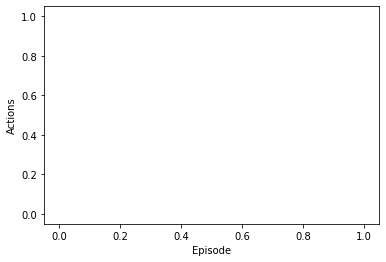

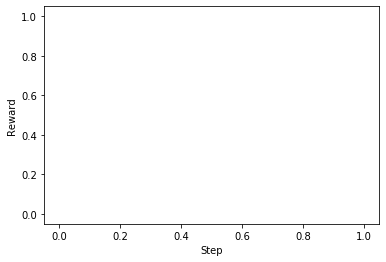

0


In [21]:
plt.plot(range(len(episode_lengths)),episode_lengths)
plt.xlabel("Episode")
plt.ylabel("Actions")
plt.savefig(f"{directory}RL_epilength.png")
plt.show()

plt.scatter(range(len(rewards)), -np.log(-np.array(rewards)))

plt.xlabel("Step")
plt.ylabel("Reward")
plt.savefig(f"{directory}RL_rewards.png")
plt.show()


print(len(memory))

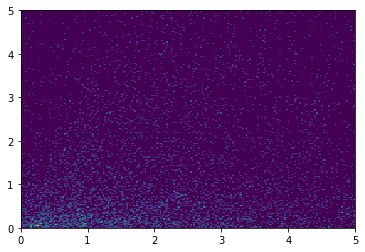

In [24]:
plt.hist2d(test_decay_length, test_vertex_error, bins=(np.linspace(0,5,200), np.linspace(0,5,200)))
plt.show()